<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Box Plots**


Estimated time needed: **45** minutes


In this lab, you will focus on the visualization of data. The dataset will be provided through an RDBMS, and you will need to use SQL queries to extract the required data.


## Objectives


In this lab you will perform the following:


-   Visualize the distribution of data.

-   Visualize the relationship between two features.

-   Visualize data composition and comparisons using box plots.


### Setup: Connecting to the Database


#### 1. Download the Database File


In [ ]:
# Download the database filE

In [4]:
import urllib.request

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/QR9YeprUYhOoLafzlLspAw/survey-results-public.sqlite"
urllib.request.urlretrieve(url, "survey-results-public.sqlite")

('survey-results-public.sqlite', <http.client.HTTPMessage at 0x2503bf8dd30>)

#### 2. Connect to the Database


**Install the needed libraries**


In [5]:
!pip install pandas

In [6]:
!pip install matplotlib

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect('survey-results-public.sqlite')


## Demo: Basic SQL Queries


#### Demo 1: Count the Number of Rows in the Table


In [8]:
QUERY = "SELECT COUNT(*) FROM main"
df = pd.read_sql_query(QUERY, conn)
print(df)


   COUNT(*)
0     65437


#### Demo 2: List All Tables


In [9]:
QUERY = """
SELECT name as Table_Name 
FROM sqlite_master 
WHERE type = 'table'
"""
pd.read_sql_query(QUERY, conn)


,Table_Name
0,main


#### Demo 3: Group Data by Age


In [10]:
QUERY = """
SELECT Age, COUNT(*) as count 
FROM main 
GROUP BY Age 
ORDER BY Age
"""
df_age = pd.read_sql_query(QUERY, conn)
print(df_age)


                  Age  count
0     18-24 years old  14098
1     25-34 years old  23911
2     35-44 years old  14942
3     45-54 years old   6249
4     55-64 years old   2575
5   65 years or older    772
6   Prefer not to say    322
7  Under 18 years old   2568


## Visualizing Data


### Task 1: Visualizing the Distribution of Data


**1. Box Plot of `CompTotal` (Total Compensation)**


Use a box plot to analyze the distribution and outliers in total compensation.


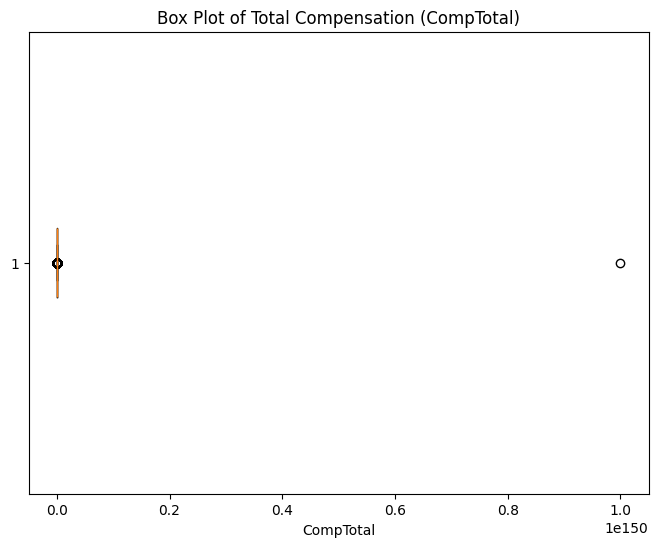

In [11]:
QUERY = "SELECT CompTotal FROM main WHERE CompTotal IS NOT NULL"
df_comp = pd.read_sql_query(QUERY, conn)

plt.figure(figsize=(8, 6))
plt.boxplot(df_comp['CompTotal'], vert=False)
plt.title('Box Plot of Total Compensation (CompTotal)')
plt.xlabel('CompTotal')
plt.show()

**2. Box Plot of Age (converted to numeric values)**


Convert the `Age` column into numerical values and visualize the distribution.


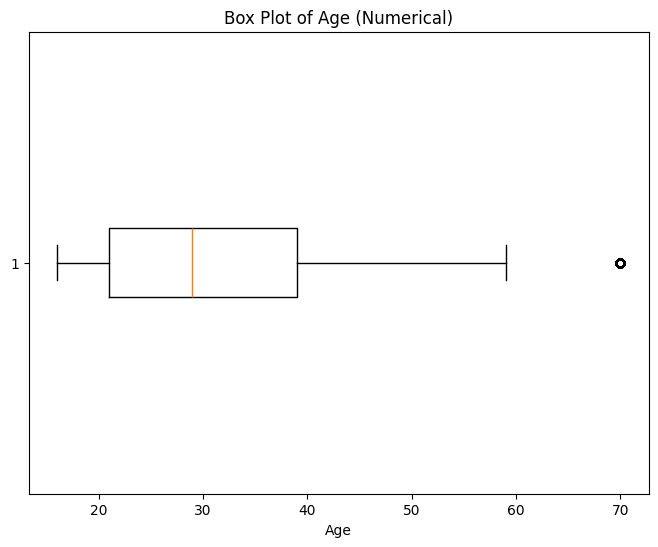

In [14]:
# Map age groups to approximate numerical values
age_map = {
    'Under 18 years old': 16,
    '18-24 years old': 21,
    '25-34 years old': 29,
    '35-44 years old': 39,
    '45-54 years old': 49,
    '55-64 years old': 59,
    '65 years or older': 70,
    'Prefer not to say': None
}

# Query Age column from the database
age_query = "SELECT Age FROM main WHERE Age IS NOT NULL"
df_age_raw = pd.read_sql_query(age_query, conn)

# Convert Age to numerical values
df_age_raw['Age_num'] = df_age_raw['Age'].map(age_map)

# Drop rows where Age_num is None
df_age_numeric = df_age_raw.dropna(subset=['Age_num'])

plt.figure(figsize=(8, 6))
plt.boxplot(df_age_numeric['Age_num'], vert=False)
plt.title('Box Plot of Age (Numerical)')
plt.xlabel('Age')
plt.show()

### Task 2: Visualizing Relationships in Data


**1. Box Plot of `CompTotal` Grouped by Age Groups:**


Visualize the distribution of compensation across different age groups.


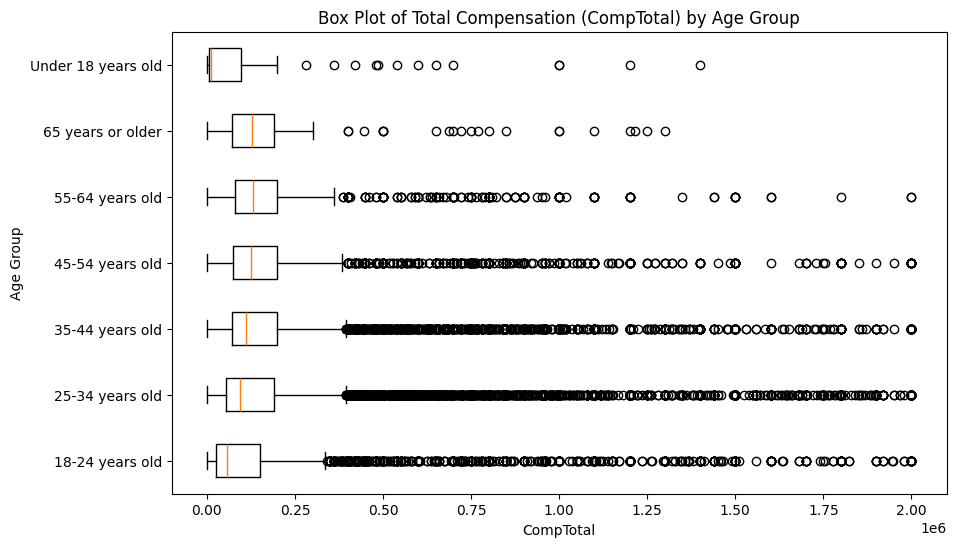

In [20]:
# Query CompTotal and Age, ignoring far outliers (CompTotal > 2,000,000)
query = """
SELECT CompTotal, Age 
FROM main 
WHERE CompTotal IS NOT NULL 
    AND Age IS NOT NULL 
    AND CompTotal <= 2000000
"""
df_comp_age = pd.read_sql_query(query, conn)

# Prepare data for boxplot
data = [df_comp_age[df_comp_age['Age'] == age]['CompTotal'] for age in age_groups]

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=age_groups, vert=False)
plt.title('Box Plot of Total Compensation (CompTotal) by Age Group')
plt.xlabel('CompTotal')
plt.ylabel('Age Group')
plt.show()

**2. Box Plot of `CompTotal` Grouped by Job Satisfaction (`JobSatPoints_6`):**


Examine how compensation varies based on job satisfaction levels.


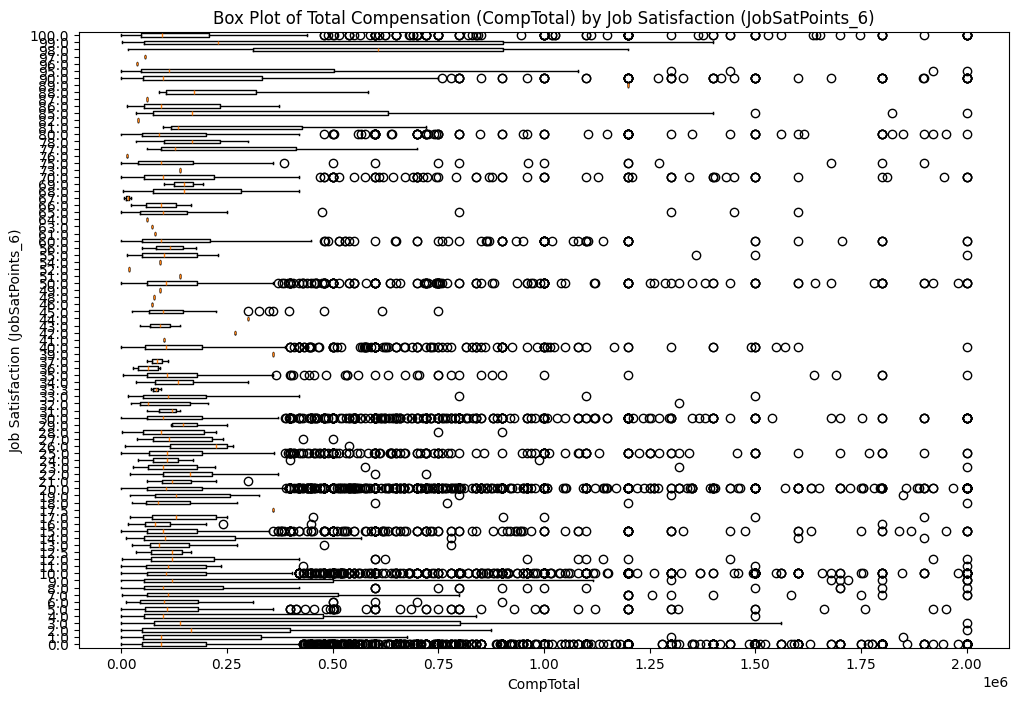

In [21]:
# Query CompTotal and JobSatPoints_6, ignoring far outliers (CompTotal > 2,000,000)
query = """
SELECT CompTotal, JobSatPoints_6
FROM main
WHERE CompTotal IS NOT NULL
    AND JobSatPoints_6 IS NOT NULL
    AND CompTotal <= 2000000
"""
df_comp_jobsat = pd.read_sql_query(query, conn)

# Get unique sorted job satisfaction levels
jobsat_levels = sorted(df_comp_jobsat['JobSatPoints_6'].unique())

# Prepare data for boxplot
jobsat_data = [df_comp_jobsat[df_comp_jobsat['JobSatPoints_6'] == level]['CompTotal'] for level in jobsat_levels]

plt.figure(figsize=(12, 8))
plt.boxplot(jobsat_data, labels=jobsat_levels, vert=False)
plt.title('Box Plot of Total Compensation (CompTotal) by Job Satisfaction (JobSatPoints_6)')
plt.xlabel('CompTotal')
plt.ylabel('Job Satisfaction (JobSatPoints_6)')
plt.show()

### Task 3: Visualizing the Composition of Data


**1. Box Plot of `ConvertedCompYearly` for the Top 5 Developer Types:**


Analyze compensation across the top 5 developer roles.


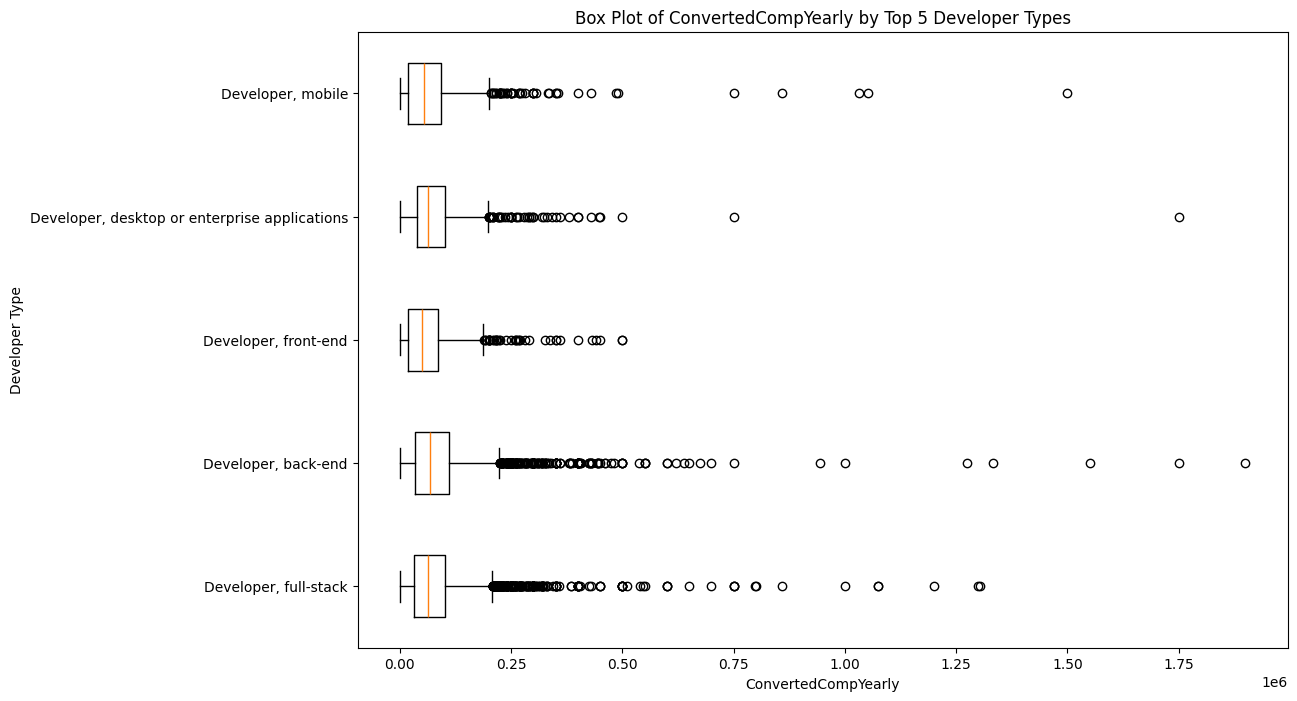

In [22]:
# Query top 5 developer types by count
query_top5_devtype = """
SELECT DevType, COUNT(*) as count
FROM main
WHERE DevType IS NOT NULL AND ConvertedCompYearly IS NOT NULL
GROUP BY DevType
ORDER BY count DESC
LIMIT 5
"""
top5_devtypes_df = pd.read_sql_query(query_top5_devtype, conn)
top5_devtypes = top5_devtypes_df['DevType'].tolist()

# Query compensation for top 5 developer types, ignoring far outliers (ConvertedCompYearly > 2,000,000)
query_comp_devtype = f"""
SELECT DevType, ConvertedCompYearly
FROM main
WHERE DevType IN ({','.join(['?']*len(top5_devtypes))})
    AND ConvertedCompYearly IS NOT NULL
    AND ConvertedCompYearly <= 2000000
"""
df_comp_devtype = pd.read_sql_query(query_comp_devtype, conn, params=top5_devtypes)

# Prepare data for boxplot
devtype_data = [df_comp_devtype[df_comp_devtype['DevType'] == dev]['ConvertedCompYearly'] for dev in top5_devtypes]

plt.figure(figsize=(12, 8))
plt.boxplot(devtype_data, labels=top5_devtypes, vert=False)
plt.title('Box Plot of ConvertedCompYearly by Top 5 Developer Types')
plt.xlabel('ConvertedCompYearly')
plt.ylabel('Developer Type')
plt.show()

**2. Box Plot of `CompTotal` for the Top 5 Countries:**


Analyze compensation across respondents from the top 5 countries.


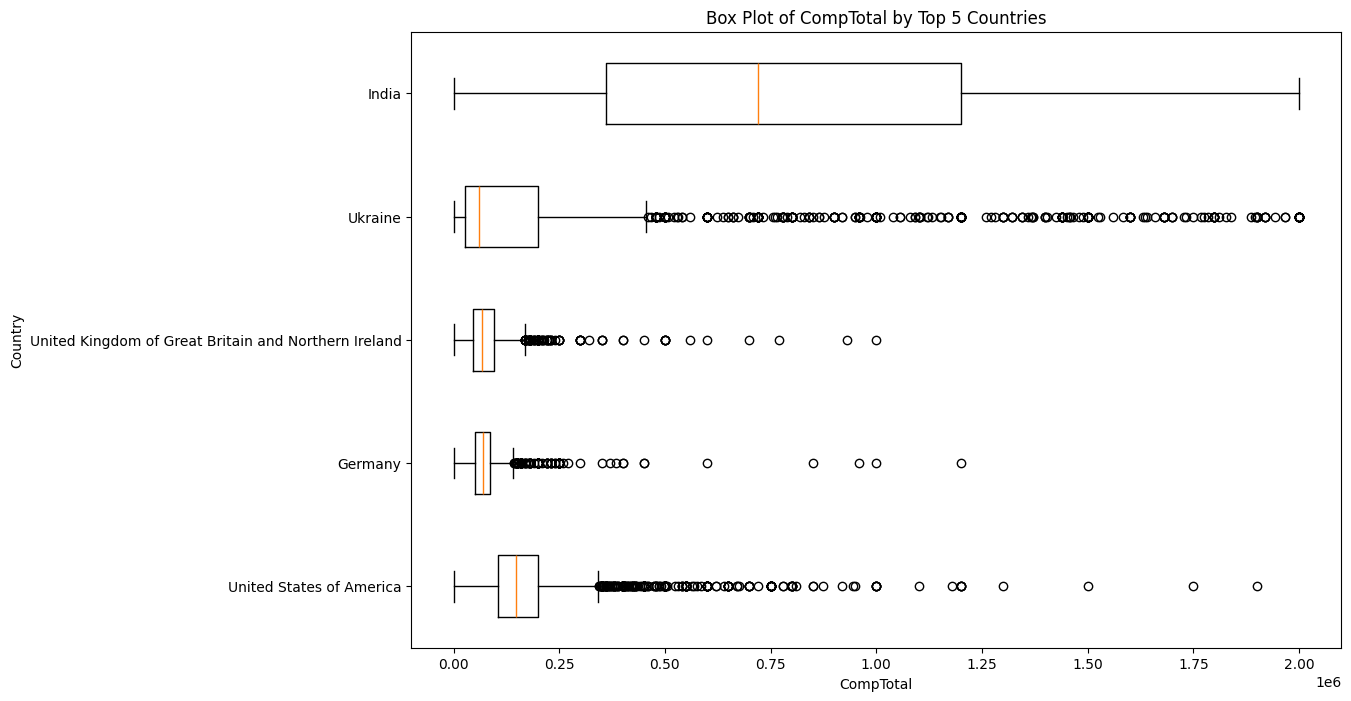

In [23]:
# Query top 5 countries by count
query_top5_country = """
SELECT Country, COUNT(*) as count
FROM main
WHERE Country IS NOT NULL AND CompTotal IS NOT NULL
GROUP BY Country
ORDER BY count DESC
LIMIT 5
"""
top5_countries_df = pd.read_sql_query(query_top5_country, conn)
top5_countries = top5_countries_df['Country'].tolist()

# Query compensation for top 5 countries, ignoring far outliers (CompTotal > 2,000,000)
query_comp_country = f"""
SELECT Country, CompTotal
FROM main
WHERE Country IN ({','.join(['?']*len(top5_countries))})
    AND CompTotal IS NOT NULL
    AND CompTotal <= 2000000
"""
df_comp_country = pd.read_sql_query(query_comp_country, conn, params=top5_countries)

# Prepare data for boxplot
country_data = [df_comp_country[df_comp_country['Country'] == country]['CompTotal'] for country in top5_countries]

plt.figure(figsize=(12, 8))
plt.boxplot(country_data, labels=top5_countries, vert=False)
plt.title('Box Plot of CompTotal by Top 5 Countries')
plt.xlabel('CompTotal')
plt.ylabel('Country')
plt.show()

### Task 4: Visualizing Comparison of Data


**1. Box Plot of CompTotal Across Employment Types:**


Analyze compensation for different employment types.


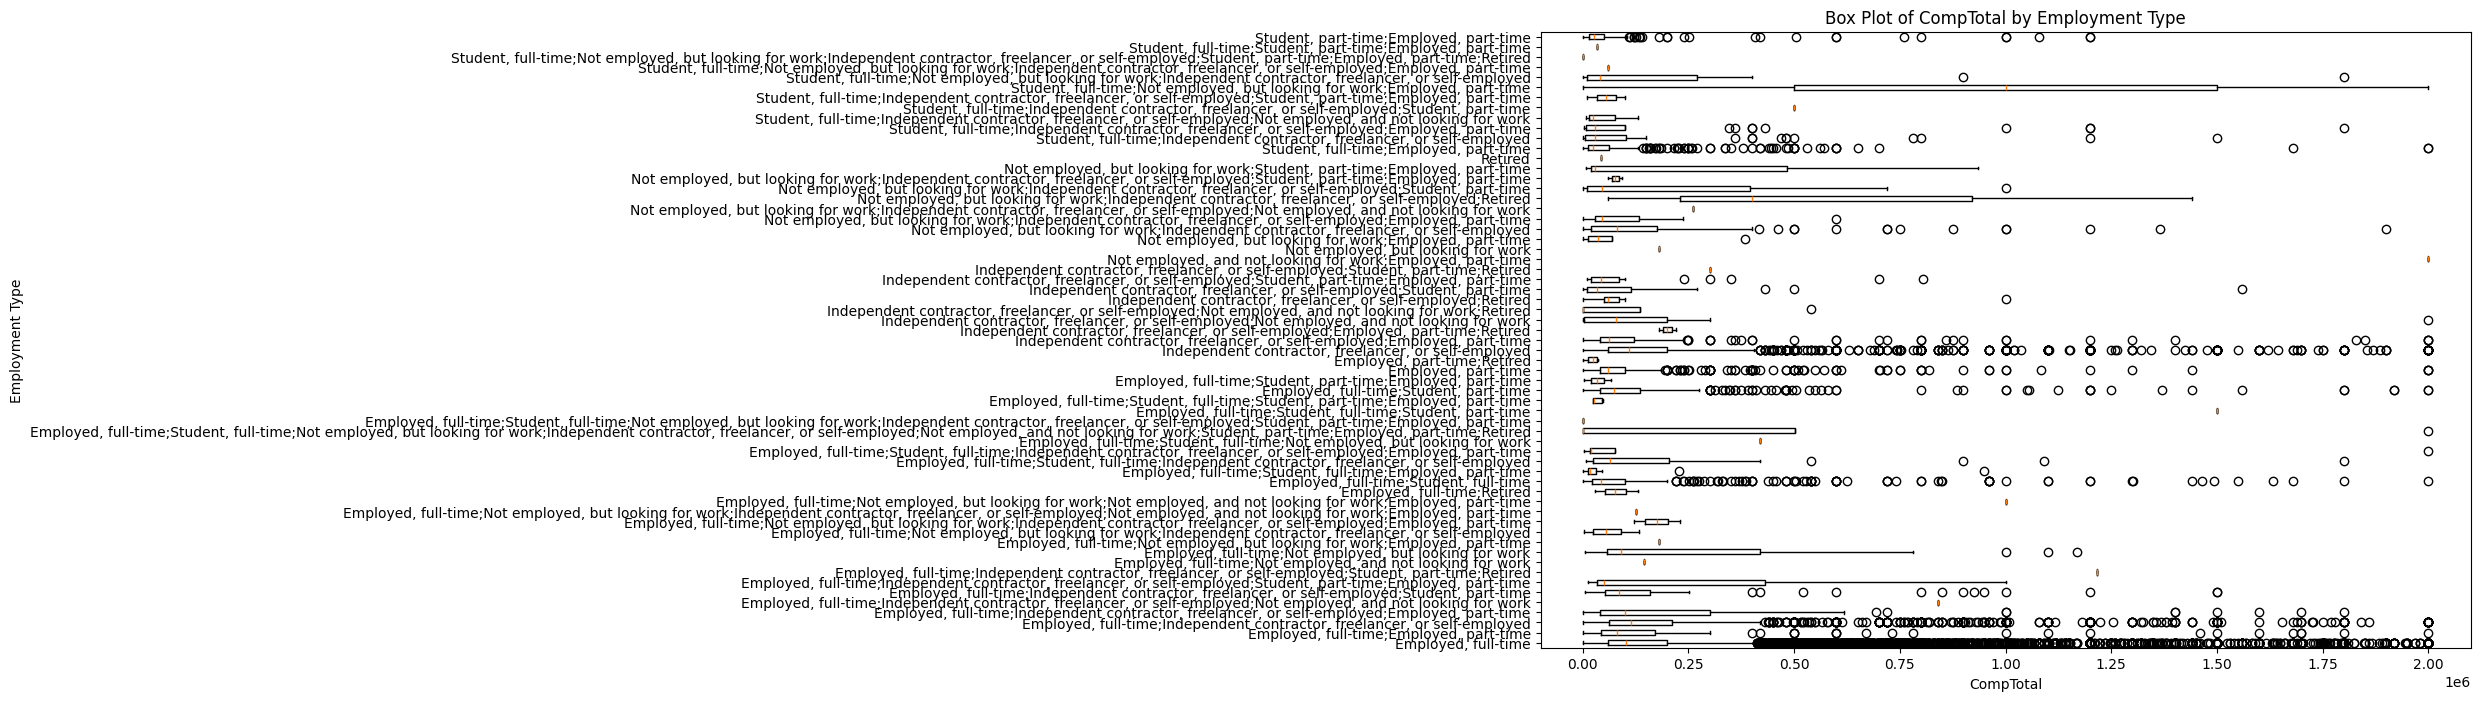

In [24]:
# Query CompTotal and Employment, ignoring far outliers (CompTotal > 2,000,000)
query = """
SELECT CompTotal, Employment
FROM main
WHERE CompTotal IS NOT NULL
    AND Employment IS NOT NULL
    AND CompTotal <= 2000000
"""
df_comp_employment = pd.read_sql_query(query, conn)

# Get unique sorted employment types
employment_types = sorted(df_comp_employment['Employment'].unique())

# Prepare data for boxplot
employment_data = [df_comp_employment[df_comp_employment['Employment'] == emp]['CompTotal'] for emp in employment_types]

plt.figure(figsize=(12, 8))
plt.boxplot(employment_data, labels=employment_types, vert=False)
plt.title('Box Plot of CompTotal by Employment Type')
plt.xlabel('CompTotal')
plt.ylabel('Employment Type')
plt.show()

**2. Box Plot of `YearsCodePro` by Job Satisfaction (`JobSatPoints_6`):**


Examine the distribution of professional coding years by job satisfaction levels.


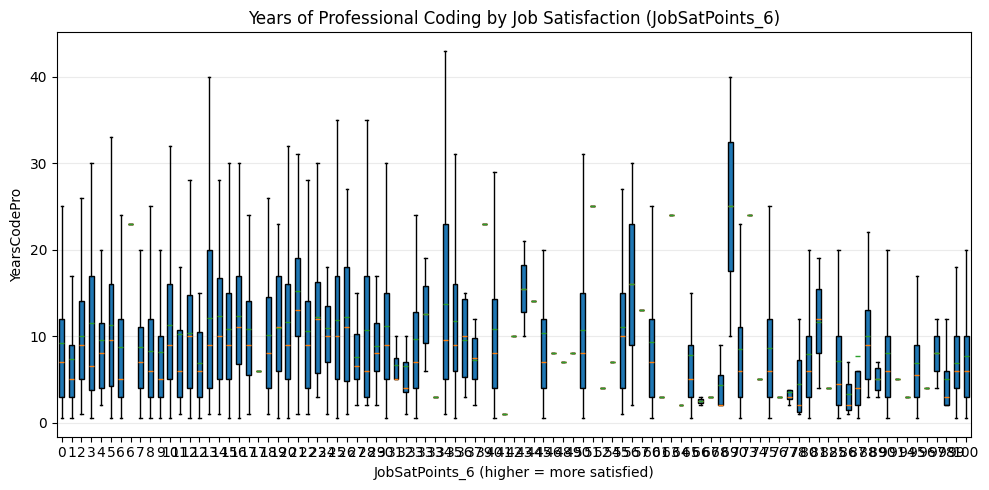

In [27]:
# your code goes here
# Box Plot of YearsCodePro by JobSatPoints_6 (hide extreme points)

import sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt

DB = "survey-results-public.sqlite"

# --- helper: find a table that has both columns ---
def find_table_with(conn, cols):
    tables = pd.read_sql_query(
        "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", conn
    )["name"].tolist()
    for t in tables:
        tcols = set(pd.read_sql_query(f"PRAGMA table_info('{t}');", conn)["name"])
        if set(cols).issubset(tcols):
            return t
    raise RuntimeError(f"No table containing columns: {cols}")

# --- 1) SQL: pull YearsCodePro + JobSatPoints_6 ---
conn = sqlite3.connect(DB)
table = find_table_with(conn, ["YearsCodePro", "JobSatPoints_6"])
q = f"""
SELECT YearsCodePro, JobSatPoints_6
FROM '{table}'
WHERE YearsCodePro IS NOT NULL AND TRIM(YearsCodePro) <> ''
  AND JobSatPoints_6 IS NOT NULL AND TRIM(JobSatPoints_6) <> ''
"""
df = pd.read_sql_query(q, conn)
conn.close()

# --- 2) Clean & convert YearsCodePro to numeric ---
yrs = (df["YearsCodePro"].astype(str).str.strip()
       .replace({"Less than 1 year": 0.5, "More than 50 years": 55}))
df["YearsCodePro"] = pd.to_numeric(yrs, errors="coerce")
df["JobSatPoints_6"] = pd.to_numeric(df["JobSatPoints_6"], errors="coerce")
df = df.dropna(subset=["YearsCodePro", "JobSatPoints_6"])
df = df[df["YearsCodePro"].between(0, 60)]

# --- 3) Order satisfaction levels & prep data per level ---
levels = sorted(df["JobSatPoints_6"].dropna().unique())
groups = [df.loc[df["JobSatPoints_6"] == lvl, "YearsCodePro"].values for lvl in levels]
labels = [str(int(l)) for l in levels]  # assume integer scale like 1..6

# --- 4) Plot: hide extreme points with showfliers=False ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(groups, labels=labels,
           showmeans=True, meanline=True,
           showfliers=False,  # <- hides outlier markers
           patch_artist=True)

ax.set_title("Years of Professional Coding by Job Satisfaction (JobSatPoints_6)")
ax.set_xlabel("JobSatPoints_6 (higher = more satisfied)")
ax.set_ylabel("YearsCodePro")
ax.grid(axis="y", alpha=0.25)
plt.tight_layout(); plt.show()


### Final Step: Close the Database Connection


After completing the lab, close the connection to the SQLite database:


In [28]:
conn.close()

## Summary


In this lab, you used box plots to visualize various aspects of the dataset, focusing on:

- Visualize distributions of compensation and age.

- Explore relationships between compensation, job satisfaction, and professional coding experience.

- Analyze data composition across developer roles and countries.

- Compare compensation across employment types and satisfaction levels.

Box plots provided clear insights into the spread, outliers, and central tendencies of various features in the dataset.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|               
|2024-10-07|1.2|Madhusudan Moole|Reviewed and updated lab|                                                                                      
|2024-10-06|1.0|Raghul Ramesh|Created lab|-->


Copyright © IBM Corporation. All rights reserved.
